## Requerimientos

In [30]:
import os
# Define the new working directory
new_wd = "C:/Users/emili/Desktop/Rosario/Trabajo de grado/Crypto_DRL - Copy (2)/" # Arreglar problemas del backslash pathlib revisar.
# Change the current working directory
os.chdir(new_wd)

# Python
import pandas as pd
import datetime
import os
import numpy as np
from importlib import reload
import yaml
 
# Reinforcement learning
import gymnasium as gym
import gym_trading_env
from gym_trading_env.downloader import download # Crypto info
from gym_trading_env.renderer import Renderer # Rendering

# Project
from my_code.utils import load_and_process_prices
from my_code.environment import Portfolio
from my_code.agents import Agent
from my_code.agents import SARSA

%reload_ext autoreload
%autoreload 2
# reload(my_code.utils)
# reload(my_code)

# Load parameters
with open(r'notebooks\params.yaml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

##### 1. Load currencies data

In [18]:
crypto_data = load_and_process_prices(
    params["crypto_pairs"], 
    params["initial_year"], 
    download_data=False)

test_df = {}

for coin in params["crypto_pairs"]:
    test_df[coin] = crypto_data[coin].head(1000)

BTC/USDT loaded (28117 rows, 6 columns)
ETH/USDT loaded (28117 rows, 6 columns)
BNB/USDT loaded (28117 rows, 6 columns)
TRX/USDT loaded (28117 rows, 6 columns)
DOT/USDT loaded (28117 rows, 6 columns)


##### 2. Build environment

In [14]:
from my_code.utils import states_generator, portfolio_action_generator 
from my_code.utils import agent_action_generator
from my_code.utils import environment_parameters_generator

# Environment parameters

## States
feature_states = states_generator(params["variation_range"], params["n_feature_states"])
nS = (params["n_actions"] ** len(params["crypto_pairs"])) * (params["n_feature_states"] ** len(params["crypto_pairs"]))

## Actions
agent_actions = [0, 1] # agent_actions = agent_action_generator(params["n_actions"])
portfolio_actions = portfolio_action_generator(
                            agent_actions, 
                            len(params["crypto_pairs"]))
portfolio_actions = [[0,0,0,0,0],[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
nA = len(portfolio_actions)

## Matrix of all available states
n_features = 1
states_matrix = (((params["n_feature_states"],) * n_features) + (params["n_actions"],)) * len(params["crypto_pairs"])

# Initialize the environment
from my_code.utils import StateInterprete

portfolio = Portfolio(
    env_params = environment_parameters_generator(crypto_data, agent_actions),
    debt_exposure=params["debt_exposure"],
    number_of_currencies=len(params["crypto_pairs"]))

# Interpretador de indices
state_interprete = StateInterprete(states_matrix=states_matrix,
                                   portfolio=portfolio,
                                   feature_states=feature_states
                                   )


In [31]:
from my_code.agents import Agent
from my_code.agents import SARSA
from my_code.agents import Q_learning
from my_code.utils import visual_policy_2f
import matplotlib.pyplot as plt

# Initialize the agent
agent_parameters = {
        'nA': nA,
        'nS': nS,
        'gamma': params["gamma"],
        'epsilon': params["epsilon"],
        'alpha': params["alpha"],
        'state_interpreter': state_interprete
        }

#agent = Q_learning(agent_parameters)
agent = SARSA(agent_parameters)

# Define the number of episodes
num_episodes = params["num_episodes"]
total_reward = 0
portfolio_price = []
total_rewards = []
avg_total_rewards =[]
policy_evolution = []

# Loop over each episode
for episode in range(num_episodes): 
    total_reward = 0
    print(f'Episode number:{episode}')

    # Reset the state of the environment and the agent
    portfolio.reset()
    agent.restart()

    observation = []
    for currency in range(len(params["crypto_pairs"])):
        observation.append(portfolio.reset()[currency][0])

    state_index = state_interprete.state_to_index(observation)
    agent.states.append(state_index)

    # visual_policy, policy_evolution, matches= visual_policy_2f(states_matrix, agent, policy_evolution, episode, feature_states)
    
    # Loop until the episode is done
    while True:
        # Genera acción y agrega a la lista de acciones

        action = agent.make_decision()
        agent.actions.append(action)

        # The agent takes a step in the environment
        observation, rewards, dones, out_of_data, info = portfolio.step(action)
        sum_rewards = sum(rewards)
        state_index = state_interprete.state_to_index(observation)

        # Actualiza el agente con los datos obtenidos
        agent.update(state_index, sum_rewards, any(dones))

        # The agent updates its state and reward history
        next_states = state_index
        agent.states.append(next_states)
        agent.rewards.append(sum_rewards)

        total_reward += sum(rewards)

        # If any of the environments is done, then the episode is done
        if any(dones) or out_of_data[0]:
            break

    # Add the total reward for this episode to the list of total rewards
    total_rewards.append(total_reward)
    avg_total_rewards.append(np.mean(total_rewards))

    # if episode % 50 == 0:
    #     display(policy_evolution)
    #     print(f'Policy acurracy: {matches}')
    #     # Print out some information about this episode
    print(f"Episode {episode + 1} finished. Total reward: {total_reward}")
    print(f"agent hyperparameters: epsilon {agent.epsilon}, alpha {agent.alpha}")

    # Protocolos de enfriamiento
    # agent.epsilon = agent.epsilon * 0.97
    # agent.alpha = 0.1 if agent.alpha <= 0.1 else agent.alpha * 0.95


# display(visual_policy)

Episode number:0
Market Return : 201.20%   |   Portfolio Return : 10.80%   |   
Market Return : 306.31%   |   Portfolio Return : -26.15%   |   
Market Return : 870.62%   |   Portfolio Return : 52.89%   |   
Market Return : 202.33%   |   Portfolio Return : 51.99%   |   
Market Return : -17.35%   |   Portfolio Return : -25.35%   |   
Episode 1 finished. Total reward: 0.3502016156894661
agent hyperparameters: epsilon 0.2, alpha 0.4
Episode number:1
Market Return : 201.20%   |   Portfolio Return : 70.87%   |   
Market Return : 306.31%   |   Portfolio Return : 89.40%   |   
Market Return : 870.62%   |   Portfolio Return : 57.99%   |   
Market Return : 202.33%   |   Portfolio Return : 327.81%   |   
Market Return : -17.35%   |   Portfolio Return : 267.32%   |   
Episode 2 finished. Total reward: 4.386344350391423
agent hyperparameters: epsilon 0.2, alpha 0.4
Episode number:2
Market Return : 201.20%   |   Portfolio Return : 28.64%   |   
Market Return : 306.31%   |   Portfolio Return : 431.94

## Test model

In [32]:
agent_SARSA_policy = agent.policy
agent_SARSA_rewards = total_rewards

print("Rewards-------------")
print(f"SARSA - Average reward: {sum(agent_SARSA_rewards) / len(agent_SARSA_rewards)}")
print(f"SARSA - Minimum reward: {min(agent_SARSA_rewards)}")
print(f"SARSA - Maximum reward: {max(agent_SARSA_rewards)}")
print("")

Rewards-------------
SARSA - Average reward: 16.91067214670074
SARSA - Minimum reward: 0.3502016156894661
SARSA - Maximum reward: 27.97029462077558



In [ ]:
portfolio = Portfolio(
    env_params = environment_parameters_generator(test_df, agent_actions),
    debt_exposure=params["debt_exposure"],
    number_of_currencies=len(params["crypto_pairs"]))

In [ ]:
pd.set_option('display.max_rows', None)  #
display(pd.DataFrame(agent.policy))
pd.reset_option('display.max_rows')

In [ ]:
visual_policy["Policy"].to_clipboard(index=False)

In [ ]:
# Probarlo con epsilon = 0
# Probarlo con datos sinteticos donde el precio solo suba
# Visualizacion de las recompensas de cada accion por estado

In [14]:
agent_q_policy = agent.policy
agent_q_rewards = total_rewards

In [30]:
agent_SARSA_policy = agent.policy
agent_SARSA_rewards = total_rewards

In [34]:
nS * 4

12800000

------------------------

## Comparasion de agentes

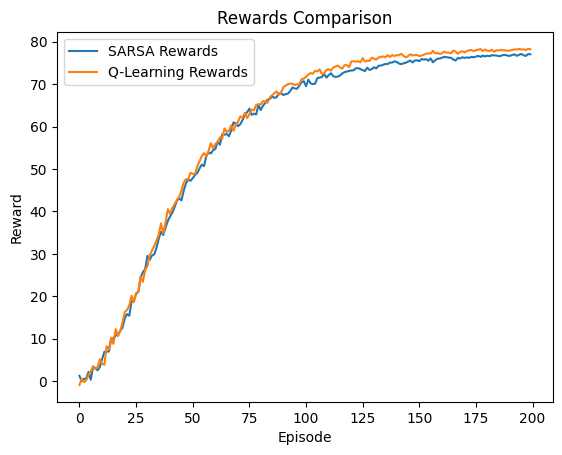

Rewards-------------
SARSA - Average reward: 58.142534737315344
SARSA - Minimum reward: 0.0021952655852762017
SARSA - Maximum reward: 77.1067693058083

Q-Learning - Average reward: 59.243689566475354
Q-Learning - Minimum reward: -0.8722169648952723
Q-Learning - Maximum reward: 78.29799434857694


In [31]:
# Graph agents rewards
plt.clf()  # Clear any existing plots
plt.plot(agent_SARSA_rewards, label='SARSA Rewards')
plt.plot(agent_q_rewards, label='Q-Learning Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards Comparison')
plt.legend()  # Add a legend to distinguish the lines
plt.draw()
plt.ioff()  # Turn off interactive mode
plt.show()

# Print rewards
print("Rewards-------------")
print(f"SARSA - Average reward: {sum(agent_SARSA_rewards) / len(agent_SARSA_rewards)}")
print(f"SARSA - Minimum reward: {min(agent_SARSA_rewards)}")
print(f"SARSA - Maximum reward: {max(agent_SARSA_rewards)}")
print("")
print(f"Q-Learning - Average reward: {sum(agent_q_rewards) / len(agent_q_rewards)}")
print(f"Q-Learning - Minimum reward: {min(agent_q_rewards)}")
print(f"Q-Learning - Maximum reward: {max(agent_q_rewards)}")

## Test Zone

### Backtesting

------------------

In [92]:
# Set new environment of non seen episodes
portfolio = Portfolio(
    env_params = environment_parameters_generator(test_df, agent_actions),
    debt_exposure=params["debt_exposure"],
    number_of_currencies=len(params["crypto_pairs"]))

# Set Agent to learning rate = 0
Agent.epsilon = 0
total_reward = 0
total_portfolio_valuation = 0
episode = "Backtesting"

# Reset the state of the environment and the agent
portfolio.reset()
agent.restart()

observation = []
for currency in range(len(params["crypto_pairs"])):
    observation.append(portfolio.reset()[currency][0])

state_index = state_interprete.state_to_index(observation)
agent.states.append(state_index)
    
# Loop until the episode is done
while True:
    # Genera acción y agrega a la lista de acciones
    action = agent.make_decision()
    agent.actions.append(action)

    # The agent takes a step in the environment
    observation, rewards, dones, out_of_data, info = portfolio.step(action)
    sum_rewards = sum(rewards)
    state_index = state_interprete.state_to_index(observation)

    # Actualiza el agente con los datos obtenidos
    agent.update(state_index, sum_rewards, any(dones))

    # The agent updates its state and reward history
    next_states = state_index
    agent.states.append(next_states)
    agent.rewards.append(sum_rewards)

    total_reward += sum(rewards)

    # If any of the environments is done, then the episode is done
    if any(dones) or out_of_data[0]:
        break

    # Add the total reward for this episode to the list of total rewards
    total_rewards.append(total_reward)
    avg_total_rewards.append(np.mean(total_rewards))

print(f"Episode {episode} finished. Total reward: {total_reward}")

Market Return : 39.33%   |   Portfolio Return : 59.66%   |   
Market Return : 18.11%   |   Portfolio Return : 65.96%   |   
Market Return : 11.90%   |   Portfolio Return : 54.12%   |   
Market Return : 32.98%   |   Portfolio Return : 70.60%   |   
Market Return : 17.93%   |   Portfolio Return : 212.36%   |   
Episode Backtesting finished. Total reward: 3.0801362042821077


In [158]:
# Set new environment of non seen episodes
portfolio = Portfolio(
    env_params = environment_parameters_generator(test_df, agent_actions),
    debt_exposure=params["debt_exposure"],
    number_of_currencies=len(params["crypto_pairs"]))

# Set Agent with learning rate = 0
Agent.epsilon = 0
total_reward = 0
total_portfolio_valuation = [5000]
episode = "Backtesting"

# Reset the state of the environment and the agent
portfolio.reset()
agent.restart()

observation = []
for currency in range(len(params["crypto_pairs"])):
    observation.append(portfolio.reset()[currency][0])

state_index = state_interprete.state_to_index(observation)
agent.states.append(state_index)
    
# Loop until the episode is done
while True:
    # Genera acción y agrega a la lista de acciones
    action = agent.make_decision()
    agent.actions.append(action)

    # The agent takes a step in the environment
    observation, rewards, dones, out_of_data, info = portfolio.step(action)
    sum_rewards = sum(rewards)
    total_portfolio_valuation.append(sum(item['portfolio_valuation'] for item in info))

    # Actualiza el agente con los datos obtenidos
    state_index = state_interprete.state_to_index(observation)
    agent.update(state_index, sum_rewards, any(dones))

    # The agent updates its state and reward history
    next_states = state_index
    agent.states.append(next_states)
    agent.rewards.append(sum_rewards)

    total_reward += sum(rewards)

    # If any of the environments is done, then the episode is done
    if any(dones) or out_of_data[0]:
        break

    # Add the total reward for this episode to the list of total rewards
    total_rewards.append(total_reward)
    avg_total_rewards.append(np.mean(total_rewards))

print(f"Episode {episode} finished. Total reward: {total_reward}")

Market Return : -3.68%   |   Portfolio Return : -2.11%   |   
Market Return : -19.17%   |   Portfolio Return : -4.50%   |   
Market Return : 24.51%   |   Portfolio Return : 33.93%   |   
Market Return : -19.88%   |   Portfolio Return : 25.20%   |   
Market Return : -31.40%   |   Portfolio Return : 25.93%   |   
Episode Backtesting finished. Total reward: 0.6799975320344783


In [160]:
# Assuming you have a list of currencies in params["currencies"]
currencies = params["crypto_pairs"]
portfolio_sum_pasive = [0] * len(df)

for currency in currencies:
    df_currency = test_df[currency]
    portfolio_values = [1000]

    for i in range(1, len(df_currency)):
        price_change = df_currency['close'][i] / df_currency['close'][i-1]
        current_value = portfolio_values[-1] * price_change
        portfolio_values.append(current_value)

    # Add the portfolio values for this currency to the portfolio_sum
    portfolio_sum_pasive = [x + y for x, y in zip(portfolio_sum_pasive, portfolio_values)]

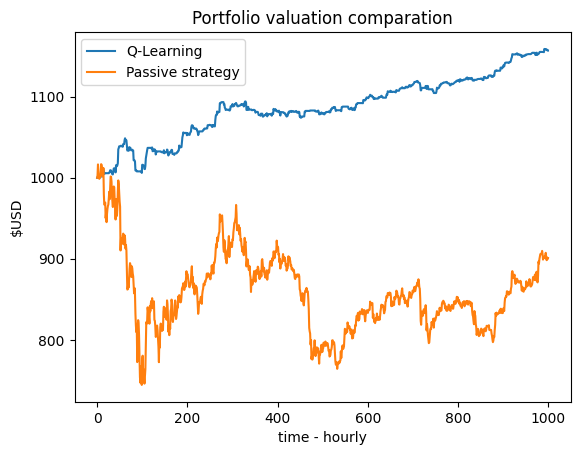

In [161]:
# Normalize
total_portfolio_valuation_ = [x / 5 for x in total_portfolio_valuation]
portfolio_sum_pasive_ = [x / 5 for x in portfolio_sum_pasive]

# Graph agents rewards
plt.clf()  # Clear any existing plots
plt.plot(total_portfolio_valuation_, label='Q-Learning')
plt.plot(portfolio_sum_pasive_, label='Passive strategy')
# plt.plot(agent_q_rewards, label='Q-Learning Rewards')
plt.xlabel('time - hourly')
plt.ylabel('$USD')
plt.title('Portfolio valuation comparation')
plt.legend()  # Add a legend to distinguish the lines
plt.draw()
plt.ioff()  # Turn off interactive mode
plt.show()

---------------------------------

In [ ]:
# Genera acción y agrega a la lista de acciones
action = agent.make_decision()
agent.actions.append(action)

action = 0

# The agent takes a step in the environment
observation, rewards, dones, out_of_data, info = portfolio.step(action)
sum_rewards = sum(rewards)
state_index = state_interprete.state_to_index(observation)

print(f'State: {observation[0][0]} {observation[0][1]} {observation[1][0]} {observation[1][1]}')
print(f'Action: {portfolio_actions[action]}')
print(f'rewards: {rewards}')
print(f'sum_rewards: {sum_rewards}')
# print(f'porfolio valuation: {info["portfolio_valuation"]}')

# Actualiza el agente con los datos obtenidos
agent.update(state_index, sum_rewards, any(dones))

# The agent updates its state and reward history
next_states = state_index
agent.states.append(next_states)
agent.rewards.append(sum_rewards)

total_reward += sum(rewards)

# Add the total reward for this episode to the list of total rewards
total_rewards.append(total_reward)

In [66]:
state_interprete.index_to_state(0)

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [80]:
mapped_values = []
for i, value in enumerate(state_interprete.index_to_state(1002110)):
    print(i)
    if i % 2 == 0:
        mapped_values.append(feature_states[value])
    else:
        mapped_values.append(value)

mapped_values

0
1
2
3
4
5
6
7
8
9


[-0.333333, 0, -0.555556, 1, -0.555556, 1, -0.555556, 1, 0.111111, 0]

In [83]:
# Funccion creacion estados
def map_state_to_lists(state_index, feature_states, state_interprete):

    mapped_values = []

    for i, value in enumerate(state_interprete.index_to_state(state_index)):
        if i % 2 == 0:
            mapped_values.append(feature_states[value])
        else:
            mapped_values.append(value)
    
    return mapped_values

# Aplicar a matriz estados
df = pd.DataFrame(agent.policy)
df['state'] = df.apply(lambda row: map_state_to_lists(row.name, feature_states, state_interprete), axis=1)
df



,0,1,2,3,4,5,state
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[-1.0, 0, -1.0, 0, -1.0, 0, -1.0, 0, -1.0, 0]"
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[-1.0, 0, -1.0, 0, -1.0, 0, -1.0, 0, -1.0, 1]"
2,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[-1.0, 0, -1.0, 0, -1.0, 0, -1.0, 0, -0.777778..."
3,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[-1.0, 0, -1.0, 0, -1.0, 0, -1.0, 0, -0.777778..."
4,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[-1.0, 0, -1.0, 0, -1.0, 0, -1.0, 0, -0.555556..."
...,...,...,...,...,...,...,...
3199995,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[1.0, 1, 1.0, 1, 1.0, 1, 1.0, 1, 0.555556, 1]"
3199996,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[1.0, 1, 1.0, 1, 1.0, 1, 1.0, 1, 0.777778, 0]"
3199997,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[1.0, 1, 1.0, 1, 1.0, 1, 1.0, 1, 0.777778, 1]"
3199998,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,"[1.0, 1, 1.0, 1, 1.0, 1, 1.0, 1, 1.0, 0]"


In [84]:
# Define the value to check
value_to_check = 0.16666666666666666

# Create a mask where all specified columns are equal to the value_to_check
mask = (df[[0, 1, 2, 3, 4, 5]] == value_to_check).all(axis=1)

# Drop these rows from the DataFrame
df = df[~mask]

In [87]:
df.to_csv('states_and_policy.csv', index=False)